**Input:** Text

**Output:** Sentiment Label [0, 1, 2]

- **0:** Negative Sentiment
- **1:** Neutral Sentiment
- **2:** Positive Sentiment

In [4]:
import numpy as np
import pandas as pd

from pythainlp import word_tokenize

from keras import regularizers
from keras import backend as K
from keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

from tensorflow.keras.regularizers import l2
from tensorflow.keras.utils import to_categorical
from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.optimizers.schedules import ExponentialDecay
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, Dense, BatchNormalization, SpatialDropout1D, Dropout

from keras.callbacks import EarlyStopping
from sklearn.preprocessing import LabelEncoder
from sklearn.utils.class_weight import compute_class_weight

import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix

In [5]:
train_df = pd.read_csv('train.csv')


## **Preprocess**


In [6]:
train_df['length'] = train_df['texts'].apply(word_tokenize).apply(len)
train_df = train_df[train_df['length'] < train_df['length'].quantile(0.95)]
train_df = train_df[train_df['length'] >= train_df['length'].quantile(0.05)]

In [7]:
train_df.category.value_counts()

neu    11886
neg     5984
pos     4100
Name: category, dtype: int64

In [8]:
class_names = np.unique(train_df.category).tolist()
class_names

['neg', 'neu', 'pos']

In [9]:
train_df.sample(n=5)

,category,texts,length
4392,pos,เอาข่าว เมื่อไร บาบีคิว พลาซ่าจะมี บุฟเฟ่. ......,18
20368,neu,สินค้า เรฟลอน โฟโต้เรดดี้ แอร์ บลัช เอฟเฟ็ค เม...,53
9514,neu,ขอเลยเหรออออ 55555 ดูคุณเเอนหิววเนอะ,15
6155,neu,😝😝😝จะเอาตัวไหน ให้ได้ 2 ตัว ทุกตัวคงไม่ไหว หน้...,22
19013,neg,เราใช้วีออส รุ่นเดียวปีเดียวกับคันที่โพส เติม3...,64


In [10]:
def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

#### Tokenizer
Before training, I converted text to numbers because models learn only from numerical. Breaking down long sentences into individual words   simplify the learning process of the model


for example

In [11]:
train_df['texts'][0]
word_tokenize(train_df['texts'][0])

['ประเทศ',
 'เรา',
 'ผลิต',
 'และ',
 'ส่งออก',
 'ยาสูบ',
 'เยอะ',
 'สุด',
 'ใน',
 'โลก',
 'จิง',
 'ป่าว',
 'คับ']

In [12]:
# Tokenize using pythainlp
train_df['tokenized_texts'] = train_df['texts'].apply(word_tokenize)

# Create a dictionary mapping words to unique integer indices
word_index = {}
for words_list in train_df['tokenized_texts']:
    for word in words_list:
        if word not in word_index:
            word_index[word] = len(word_index) + 1  # Start indexing from 1

# Convert the text sequences to integer sequences based on the word_index
train_df['sequences'] = train_df['tokenized_texts'].apply(lambda words_list: [word_index[word] for word in words_list])

# Get the maximum sequence length
max_length = max(len(sequence) for sequence in train_df['sequences'])
print("Maximum Sequence Length:", max_length)

Maximum Sequence Length: 99


### Padding sequence

<li> help us receive input text sentences with different range for training with neural network that have to fixed size input by multiplying input method like zero padding


for example

Original Sequence 1: `[1, 2, 3]` | Padded Sequence 1: `[0, 1, 2, 3]`

Original Sequence 2: `[4, 5]` | Padded Sequence 2: `[0, 0, 4, 5]`



In [13]:
# Padding sequences
X = pad_sequences(train_df['sequences'], maxlen=max_length)
X[0]

array([ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13],
      dtype=int32)

In [14]:
X.shape

(21970, 99)

In [15]:
label_mapping = {'neg': 0, 'neu': 1, 'pos': 2}
y_num = train_df['category'].map(label_mapping)

In [16]:
train_df['labels'] = train_df['category'].map(label_mapping)
print(train_df[['labels', 'texts']])


       labels                                              texts
0           1  ประเทศเราผลิตและส่งออกยาสูบเยอะสุดในโลกจิงป่าวคับ
2           0                        อิเหี้ยออมทำกูอยากกินเอ็มเค
4           1                            สวัสดีวันพุธ แนน อะไรนะ
5           1  ก้อนขอบพระคุณมากๆนะคร้าบ ที่มาหาก้อนและชมเชยกา...
7           1                                 ปากแดงกินฟรีค่ะ 😬😬
...       ...                                                ...
23540       0                                     แม่งควายล้วนนน
23541       0                   ดอยสุเทพน้องง ไปหมดแล้วววว #pm25
23542       0                           ค่าชุดอาจจะแพงกว่าส่วนลด
23543       1                              รัฐต้องการแค่ภาษีครับ
23544       1  ™ ได้พัฒนาระบบเข้าสู่รุ่นที่สองแล้ว มาดูกันสิว...

[21970 rows x 2 columns]


In [17]:
np.unique(y_num)

array([0, 1, 2])

For the process of changing numerical labels to one-hot vectors:

1. Utilize `to_categorical` to convert numerical labels to one-hot encoded vectors.
2. For instance:
   - 'positive' is represented as [0, 0, 1]
   - 'negative' is represented as [1, 0, 0]
   - 'neutral' is represented as [0, 1, 0]

In [18]:
y = to_categorical(y_num)

# Vocabulary size
vocab_size = len(word_index) + 1
print("Vocabulary size:", vocab_size)


Vocabulary size: 23825


In [19]:
y.shape

(21970, 3)

In [20]:
train_df['tokenized_texts']

0        [ประเทศ, เรา, ผลิต, และ, ส่งออก, ยาสูบ, เยอะ, ...
2            [อิ, เหี้ย, ออม, ทำ, กู, อยาก, กิน, เอ็ม, เค]
4                  [สวัสดี, วัน, พุธ,  , แนน,  , อะไร, นะ]
5        [ก้อน, ขอบพระคุณ, มาก, ๆ, นะ, คร้าบ,  , ที่, ม...
7                         [ปาก, แดง, กิน, ฟรี, ค่ะ,  , 😬😬]
                               ...                        
23540                             [แม่, ง, ควาย, ล้วน, นน]
23541    [ดอย, สุเทพ, น้อง, ง,  , ไป, หมด, แล้ว, ววว,  ...
23542                 [ค่า, ชุด, อาจจะ, แพง, กว่า, ส่วนลด]
23543                      [รัฐ, ต้องการ, แค่, ภาษี, ครับ]
23544    [™,  , ได้, พัฒนา, ระบบ, เข้าสู่, รุ่น, ที่สอง...
Name: tokenized_texts, Length: 21970, dtype: object

# "LSTM" Model

## Reasons for Choosing LSTM

- **Sequential Data Suitability:**
  - LSTM is particularly suitable for sequential data, making it an ideal choice for tasks like sentiment analysis.
  - "LSTM is designed to capture long-range dependencies," allowing it to understand the context of words in a sentence.

- **Handling Vanishing Gradient:**
  - LSTM addresses the vanishing gradient problem inherent in training deep neural networks.
  - Utilizes a memory cell, forget gate, and residual connections to help the network remember previous sentences, forget unnecessary input, and prevent vanishing gradient issues, especially in long sentences.

- **Memory Cell for Long-Term Information:**
  - The memory cell in LSTM enables the model to store and retrieve information over extended periods.
  - This feature allows the model to remember contextual information, contributing to a better understanding of the overall sequence.



#### How LSTM Works

1. **Input Sequences:**
   - Input sequences consist of a sequence of words, with each word represented as a vector.

2. **Sequence Processing:**
   - LSTM processes the input one element at a time.
   - It captures information from earlier parts of the sentences, both in the forward and backward directions.

3. **Memory Cells:**
   - LSTM utilizes memory cells to collect the state.
   - Memory cells selectively remember or forget information over long sequences.

4. **Gates:**
   - LSTM gates control the flow of information.
     - **Input Gate:**
       - Decides which information to add to the memory cell (cell state).
     - **Forget Gate:**
       - Decides which information to discard from the memory cell.
         - *How does the forget gate work?*
           - The forget gate examines the input data along with the hidden state and uses sigmoid activation to decide.
     - **Output Gate:**
       - Decides what to output based on the current input and the memory cell's content.

5. **Backpropagation Through Time:**
   - Propagates the error back through the entire sequence.
   - Updates the weights at each time step to improve the model's performance.



# Model Architecture

## 1. Embedding Layer

- Converts input sequences into dense vectors.
- Helps in representing words as continuous vectors, making model implementation easier.
- **Parameters:**
  - `input_dim`: Size of the vocabulary.
  - `output_dim`: Size of the output dense vector representation for each word.
  - `max_length`: Maximum length of input sequences.

## 2. Spatial Dropout

- Applies dropout specifically to the embedding layers.
- Randomly selects neurons to ignore during training.

## 3. Bidirectional LSTM

- Connects LSTM layers in both forward and backward directions.
- Allows the LSTM to process input sequences bidirectionally.

## 4. BatchNormalization

- Normalizes the activations of the previous layer.
- Stabilizes and accelerates the training process.

## 5. Dense Layers

- **`Dense(64)`**
  - Acts as a feature extractor, reducing dimensionality before the final classification.
  - **Activation Function:** Hyperbolic tangent (tanh).
  - **Regularization:** L2 regularization with a coefficient of 0.01.

- **`Dense(3)`**
  - Produces the final output probabilities for classification.
  - **Activation Function:** Softmax.


In [21]:
initial_learning_rate = 1e-3
lr_schedule = ExponentialDecay(
    initial_learning_rate=initial_learning_rate,
    decay_steps=10000,
    decay_rate=0.9
)

model = Sequential([
    Embedding(input_dim=vocab_size, output_dim=128, input_length=max_length),
    SpatialDropout1D(0.2),
    Bidirectional(LSTM(50, dropout=0.2, recurrent_dropout=0, return_sequences=True)),
    BatchNormalization(),
    Bidirectional(LSTM(50, dropout=0.2, recurrent_dropout=0)),
    BatchNormalization(),
    Dense(64, activation='tanh', kernel_regularizer=l2(0.01)),
    Dense(3, activation='softmax')
])
optimizer = Adam(learning_rate=initial_learning_rate)

model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['acc',f1_m,precision_m, recall_m])


In [22]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 99, 128)           3049600   
                                                                 
 spatial_dropout1d (Spatial  (None, 99, 128)           0         
 Dropout1D)                                                      
                                                                 
 bidirectional (Bidirection  (None, 99, 100)           71600     
 al)                                                             
                                                                 
 batch_normalization (Batch  (None, 99, 100)           400       
 Normalization)                                                  
                                                                 
 bidirectional_1 (Bidirecti  (None, 100)               60400     
 onal)                                                  

### Training

#### Class Weight
- Using class weights to address class imbalance in the dataset ensures that the model gives higher weight to minority classes, preventing them from being overshadowed by the majority class.


In [23]:
early_stopping = EarlyStopping(monitor='val_f1_m', patience=10, restore_best_weights=True)

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

class_weights = compute_class_weight(
                                        class_weight = "balanced",
                                        classes = np.unique(y_num),  # numerical
                                        y = y_num # numerical
                                    )
class_weights_dict = dict(zip(np.unique(y_num), class_weights))

In [24]:
class_weights_dict

{0: 1.223819073083779, 1: 0.6161310224914465, 2: 1.7861788617886178}

In [25]:
history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_val, y_val), callbacks=[early_stopping], class_weight=class_weights_dict)


Epoch 1/100
550/550 [==============================] - 53s 66ms/step - loss: 1.3108 - acc: 0.5552 - f1_m: 0.5036 - precision_m: 0.5947 - recall_m: 0.4399 - val_loss: 0.9363 - val_acc: 0.6723 - val_f1_m: 0.6460 - val_precision_m: 0.7153 - val_recall_m: 0.5904
Epoch 2/100
550/550 [==============================] - 16s 30ms/step - loss: 0.7472 - acc: 0.7146 - f1_m: 0.7021 - precision_m: 0.7407 - recall_m: 0.6685 - val_loss: 0.8851 - val_acc: 0.6170 - val_f1_m: 0.6048 - val_precision_m: 0.6364 - val_recall_m: 0.5771
Epoch 3/100
550/550 [==============================] - 16s 29ms/step - loss: 0.5056 - acc: 0.7959 - f1_m: 0.7937 - precision_m: 0.8141 - recall_m: 0.7751 - val_loss: 0.8895 - val_acc: 0.6509 - val_f1_m: 0.6469 - val_precision_m: 0.6666 - val_recall_m: 0.6289
Epoch 4/100
550/550 [==============================] - 16s 29ms/step - loss: 0.3810 - acc: 0.8425 - f1_m: 0.8411 - precision_m: 0.8529 - recall_m: 0.8301 - val_loss: 0.9887 - val_acc: 0.6115 - val_f1_m: 0.6042 - val_precisi

#### Evaluation

- **Evaluation Summarization:**
  - Due to the inherent imbalance in my dataset, the focus of the evaluation is on key metrics including precision, F1-score, and recall.
    - Precision: Measuring the accuracy of positive predictions.(How well model predict)
    - F1-score: Balancing precision and recall, particularly important in imbalanced datasets.
    - Recall: Capturing the ability to identify all relevant instances, especially vital for minority classes.


In [26]:
score = model.evaluate(X_val, y_val, verbose=1, batch_size=32)


138/138 [==============================] - 1s 10ms/step - loss: 0.9887 - acc: 0.6115 - f1_m: 0.6042 - precision_m: 0.6263 - recall_m: 0.5843


In [27]:
test_df = pd.read_csv('test.csv')

In [28]:
test_df['tokenized_texts'] = test_df['texts'].apply(word_tokenize)

# Convert the text sequences to integer sequences based on the existing word_index
test_df['sequences'] = test_df['tokenized_texts'].apply(lambda words_list: [word_index.get(word, 0) for word in words_list])

# Padding sequences
X_test = pad_sequences(test_df['sequences'], maxlen=max_length)

test_labels = test_df['category'].map(label_mapping)
y_test = to_categorical(test_labels)


In [29]:
predictions = model.predict(X_test)

predicted_labels = np.argmax(predictions, axis=1)

84/84 [==============================] - 3s 11ms/step


In [30]:
y_test_original = np.argmax(y_test, axis=1)


# Conclusion

The model's performance is relatively balanced across three classes with precision, recall, and F1-score around 33%.

## Confusion Matrix Analysis

- **Highest Correct Predictions: Class Negative**
  - The class that made the highest number of correct predictions is the Negative Sentiment class. Negative sentiment sentences appear to be more straightforward for the model to decide.

- **Highest Mispredictions: Class Neutral**
  - The class with the highest number of mispredictions is the Neutral Sentiment class. Deciding between Neutral and Positive sentiments can be challenging, even for a human reader. This difficulty is reflected in the model's mispredictions, making sense given the inherent ambiguity in neutral statements.

In summary, the model performs well in distinguishing negative sentiments but faces challenges in accurately classifying neutral sentiments, reflecting the inherent difficulty in differentiating between neutral and positive expressions.


              precision    recall  f1-score   support

           0       0.31      0.31      0.31       891
           1       0.30      0.31      0.30       892
           2       0.33      0.33      0.33       891

    accuracy                           0.32      2674
   macro avg       0.32      0.32      0.32      2674
weighted avg       0.32      0.32      0.32      2674



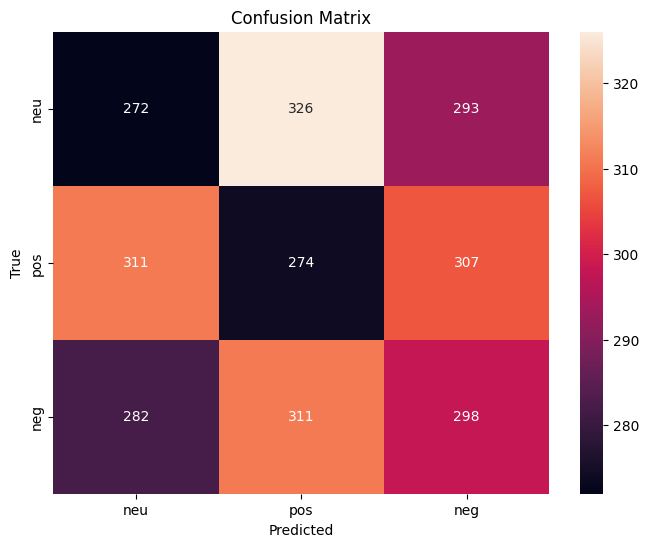

In [31]:
# Evaluate classification report
classification_report(y_test_original, predicted_labels)
print(classification_report(y_test_original, predicted_labels))

conf_matrix = confusion_matrix(y_test_original, predicted_labels)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', xticklabels=['neu', 'pos', 'neg'], yticklabels=['neu', 'pos', 'neg'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

### Performance evaluation

<li> Check for the model predict wrong classes

In [32]:
incorrect_indices = np.where(predicted_labels != y_test_original)[0]

num_to_print = min(20, len(incorrect_indices))

for i in range(num_to_print):
    index = incorrect_indices[i]
    print("Index:", index)
    print("Predicted Probabilities:", np.max(predictions[index], axis=0))
    print("Predicted Class:", predicted_labels[index])
    print("True Class:", y_test_original[index])
    print("Text:", test_df['texts'].iloc[index])
    print("\n")


Index: 0
Predicted Probabilities: 0.9815492
Predicted Class: 0
True Class: 1
Text: ซื้อแต่ผ้าอนามัยแบบเย็นมาค่ะ แบบว่าอีห่ากูนอนไม่ได้


Index: 1
Predicted Probabilities: 0.5255274
Predicted Class: 1
True Class: 2
Text: ครับ #phithanbkk


Index: 5
Predicted Probabilities: 0.89379686
Predicted Class: 2
True Class: 0
Text: เคล็ดลับที่ขาดไม่ได้ในการป้องกันผิวจากแสงแดด คือการทาครีมกันแดด สาวๆบ้างคนอาจจะคิดว่ามันไม่ใช่เรื่องสำคัญเท่าไหร่ แต่บอกเลยว่า ผิดมาก เพราะแสงแดดสมัยนี้แรงมาก และมีอนุภาพการทำลายผิวสูงมาก ถ้าไม่อยากให้ผิวเราถูกทำร้ายแบบซ้ำๆซาก ควรทาครีมกันแดดที่ดีมีคุณภาพอย่าง Eucerin Sun Age Repair Serum ปัจจุบันครีมกันแดดมีมากมายให้เราเลือกซื้อก็จริง แต่ก็อย่าลืมเลือกสิ่งที่ดีที่สุดให้ตัวเราอย่าง Eucerin Sun Acne oil Control ค่ะ


Index: 6
Predicted Probabilities: 0.98282444
Predicted Class: 0
True Class: 1
Text: สำหรับสูตรของผม คือ Jack Daniel's หวานซ่อนเปรี้ยวชื่อ Jack Yellow Life ส่วนประกอบ Jack Daniel's 2 ชอท น้ำเก๊กฮวย น้ำมะนาว ใบมิ้นท์ เกลือเล็กน้อย วิธีปรุง นำ JackDaniel's มาเ

### Most wrongs predicted classes

  1. Class 1, which represents neutral sentiment, is the most misclassified.
     - This may be due to a higher representation of the neutral class in the dataset.
  2. The neutral class is particularly challenging to determine accurately.


In [33]:
from collections import Counter

misclassified_classes_counter = Counter(y_test_original[incorrect_indices])

# Find the most frequently misclassified class
most_wrong_class, misclassification_count = misclassified_classes_counter.most_common(1)[0]

for predicted_class, misclassification_count in misclassified_classes_counter.items():
    print(f"Predicted Class: {predicted_class}, Misclassification Count: {misclassification_count}")

Predicted Class: 1, Misclassification Count: 618
Predicted Class: 2, Misclassification Count: 593
Predicted Class: 0, Misclassification Count: 619


### Test model evaluation

In [34]:
input_text = "สวัสดีวันนี้วันพฤหัสบดี วันดีๆ"


In [35]:
input_sequence = word_tokenize(input_text)

input_indices = [word_index[word] for word in input_sequence if word in word_index]

# Pad the sequence
padded_input = pad_sequences([input_indices], maxlen=max_length, padding='post')  # Assuming 'post' padding

# Make predictions
predicted_probabilities = model.predict(padded_input)

predicted_label = np.argmax(predicted_probabilities, axis=1)[0]

predicted_category = predicted_label

print("Input Text:", input_text)
print("Tokenized Input Sequence:", input_sequence)
print(f"Predicted Category, the ground truth label is {np.unique(train_df.category)}:", predicted_category) # class 2 is positve
print("Predicted Probabilities:", np.max(predicted_probabilities))

1/1 [==============================] - 0s 65ms/step
Input Text: สวัสดีวันนี้วันพฤหัสบดี วันดีๆ
Tokenized Input Sequence: ['สวัสดี', 'วันนี้', 'วัน', 'พฤหัสบดี', ' ', 'วันดี', 'ๆ']
Predicted Category, the ground truth label is ['neg' 'neu' 'pos']: 2
Predicted Probabilities: 0.74707687


In [36]:
input_text = "เมื่อไหร่จะวันศุกร์ ขี้เกียจทำงานน"


In [37]:
input_sequence = word_tokenize(input_text)

input_indices = [word_index[word] for word in input_sequence if word in word_index]

# Pad the sequence
padded_input = pad_sequences([input_indices], maxlen=max_length, padding='post')  # Assuming 'post' padding

# Make predictions
predicted_probabilities = model.predict(padded_input)

predicted_label = np.argmax(predicted_probabilities, axis=1)[0]

predicted_category = predicted_label

print("Input Text:", input_text)
print("Tokenized Input Sequence:", input_sequence)
print(f"Predicted Category, the ground truth label is {np.unique(train_df.category)}:", predicted_category) # class 2 is positve
print("Predicted Probabilities:", np.max(predicted_probabilities))

1/1 [==============================] - 0s 23ms/step
Input Text: เมื่อไหร่จะวันศุกร์ ขี้เกียจทำงานน
Tokenized Input Sequence: ['เมื่อไหร่', 'จะ', 'วัน', 'ศุกร์', ' ', 'ขี้เกียจ', 'ทำงาน', 'น']
Predicted Category, the ground truth label is ['neg' 'neu' 'pos']: 2
Predicted Probabilities: 0.8227339


In [38]:
input_text = "อยากกินขนม"


In [39]:
input_sequence = word_tokenize(input_text)

input_indices = [word_index[word] for word in input_sequence if word in word_index]

# Pad the sequence
padded_input = pad_sequences([input_indices], maxlen=max_length, padding='post')  # Assuming 'post' padding

# Make predictions
predicted_probabilities = model.predict(padded_input)

predicted_label = np.argmax(predicted_probabilities, axis=1)[0]

predicted_category = predicted_label

print("Input Text:", input_text)
print("Tokenized Input Sequence:", input_sequence)
print(f"Predicted Category, the ground truth label is {np.unique(train_df.category)}:", predicted_category) # class 2 is positve
print("Predicted Probabilities:", np.max(predicted_probabilities))

1/1 [==============================] - 0s 25ms/step
Input Text: อยากกินขนม
Tokenized Input Sequence: ['อยาก', 'กิน', 'ขนม']
Predicted Category, the ground truth label is ['neg' 'neu' 'pos']: 2
Predicted Probabilities: 0.71482617


### Conclusion

The model shows signs of overfitting due to data ambiguity. To address this, I've adjusted metrics and explored LSTM enhancements, including dropout, early stopping, and regularization. Future plans involve l
everaging pre-trained models when resources allow, along with a focus on feature engineering and data augmentation.